# PyTorch main functionalities
## 1. Automatic gradient calculations (today and maybe next class)
## 2. GPU acceleration (probably won't cover)
## 3. Neural network functions (hopefully cover a few common operations later)

In [1]:
import numpy as np
import torch # PyTorch library
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
# To visualize computation graphs
# See: https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot, make_dot_from_trace
sns.set()
%matplotlib inline

# PyTorch: Some basics of converting between NumPy and Torch

In [2]:
# Torch and numpy
x = torch.linspace(-5,5,10)
print(x)
print(x.dtype)
print('NOTE: x is float32 (torch default is float32)')
x_np = np.linspace(-5,5,10)
y = torch.from_numpy(x_np)
print(y)
print(y.dtype)
print('NOTE: y is float64 (numpy default is float64)')
print(y.float().dtype)
print('NOTE: y can be converted to float32 via `float()`')
print(x.numpy())
print(y.numpy())

tensor([-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
         3.8889,  5.0000])
torch.float32
NOTE: x is float32 (torch default is float32)
tensor([-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
         3.8889,  5.0000], dtype=torch.float64)
torch.float64
NOTE: y is float64 (numpy default is float64)
torch.float32
NOTE: y can be converted to float32 via `float()`
[-5.         -3.8888888  -2.7777777  -1.6666665  -0.55555534  0.5555558
  1.666667    2.7777781   3.8888893   5.        ]
[-5.         -3.88888889 -2.77777778 -1.66666667 -0.55555556  0.55555556
  1.66666667  2.77777778  3.88888889  5.        ]


# Torch can be used to do simple computations 

In [3]:
# Explore gradient calculations
x = torch.tensor(5.0)
y = 3*x**2 + x
print(x, x.grad)
print(y)

tensor(5.) None
tensor(80.)


# PyTorch automatically creates a computation graph for computing gradients  if `requires_grad=True`

# IMPORTANT: You must set `requires_grad=True` for any torch tensor for which you will want to compute the gradient
## These are known as the "leaf nodes" or "input nodes" of a gradient computation graph

# Okay let's compute and show the computation graph

tensor(5., requires_grad=True) None
tensor(5.1232, grad_fn=<AddBackward0>)


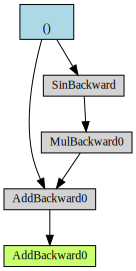

In [4]:
# Explore gradient calculations
x = torch.tensor(5.0, requires_grad=True)
y = 3*x**2 + x+3
y = 3*torch.sin(x) + x+3
print(x, x.grad)
print(y)
make_dot(y)

tensor(42., grad_fn=<MulBackward0>) None
tensor(42., grad_fn=<MulBackward0>)


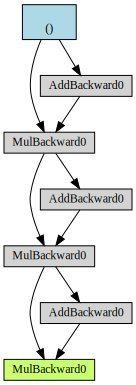

In [5]:
# We can even do loops
x = torch.tensor(1.0, requires_grad=True)
for i in range(3):
    x = x*(x+1)
y = x
print(x, x.grad)
print(y)
make_dot(y)

## Now we can automatically compute gradients via backward call
### Note that tensor has grad_fn for doing the backwards computation

In [6]:
y.backward()
print(x, x.grad)
print(y)

tensor(42., grad_fn=<MulBackward0>) None
tensor(42., grad_fn=<MulBackward0>)


## A call to `backward` will free up **implicit** computation graph

In [7]:
try:
    y.backward()
    print(x, x.grad)
    print(y)
except Exception as e:
    print(e)

Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.


# Gradients accumulate, i.e., sum

In [8]:
x = torch.tensor(5.0, requires_grad=True)
for i in range(2):
    y = 3*x**2
    y.backward()
    print(x, x.grad)
    print(y)

tensor(5., requires_grad=True) tensor(30.)
tensor(75., grad_fn=<MulBackward0>)
tensor(5., requires_grad=True) tensor(60.)
tensor(75., grad_fn=<MulBackward0>)


# Thus, must zero gradients before calling `backward()`

In [9]:
# Thus if before calling another gradient iteration, zero the gradients
x.grad.zero_()
print(x, x.grad)

# Now that gradient is zero, we can do again
y = 3*x**2
y.backward()
print(x, x.grad)
print(y)

tensor(5., requires_grad=True) tensor(0.)
tensor(5., requires_grad=True) tensor(30.)
tensor(75., grad_fn=<MulBackward0>)


# PyTorch can compute gradients for any number of parameters, just make sure to set requires_grad=True

In [10]:
x = torch.arange(5, dtype=torch.float32).requires_grad_(True)
y = torch.sum(x**2)
y.backward()
print(y)
print(x)
print('Grad', x.grad)

tensor(30., grad_fn=<SumBackward0>)
tensor([0., 1., 2., 3., 4.], requires_grad=True)
Grad tensor([0., 2., 4., 6., 8.])


# More complicated gradients example

In [11]:
x = torch.arange(5, dtype=torch.float32).requires_grad_(True)
y = torch.mean(torch.log(x**2+1)+5*x)
y.backward()
print(y)
print(x)
print('Grad', x.grad)

tensor(11.4877, grad_fn=<MeanBackward0>)
tensor([0., 1., 2., 3., 4.], requires_grad=True)
Grad tensor([1.0000, 1.2000, 1.1600, 1.1200, 1.0941])


# Now let's optimize a non-convex function (pretty much all DNNs)

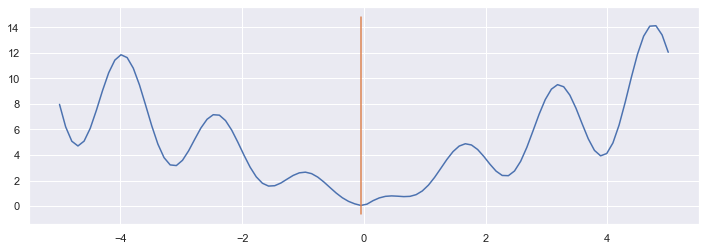

In [12]:
def objective(theta):
    return theta*torch.cos(4*theta) + 2*torch.abs(theta)

theta = torch.linspace(-5, 5)
y = objective(theta)
theta_true = float(theta[np.argmin(y)])
plt.figure(figsize=(12,4))
plt.plot(theta.numpy(), y.numpy())
plt.plot(theta_true * np.ones(2), plt.ylim())

# Let's use simple gradient descent on this function

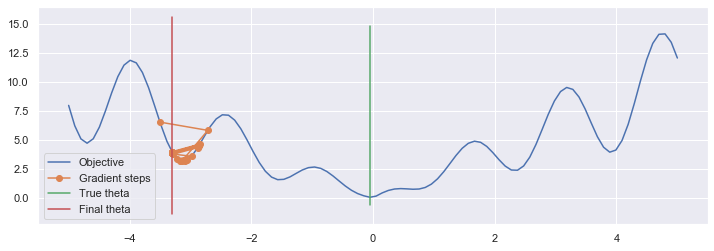

In [13]:
def gradient_descent(objective, step_size=0.05, max_iter=100, init=0):
    # Initialize
    theta_hat = torch.tensor(init, requires_grad=True)
    theta_hat_arr = [theta_hat.detach().numpy().copy()]
    obj_arr = [objective(theta_hat).detach().numpy()]
    # Iterate
    for i in range(max_iter):
        # Compute gradient
        if theta_hat.grad is not None:
            theta_hat.grad.zero_()
        out = objective(theta_hat)
        out.backward()

        # Update theta in-place
        with torch.no_grad():
            theta_hat -= step_size * theta_hat.grad
        theta_hat_arr.append(theta_hat.detach().numpy().copy())
        obj_arr.append(objective(theta_hat).detach().numpy())
    return np.array(theta_hat_arr), np.array(obj_arr)

def visualize_results(theta_arr, obj_arr, objective, theta_true=None, vis_arr=None):
    if vis_arr is None:
        vis_arr = np.linspace(np.min(theta_arr), np.max(theta_arr))
    fig = plt.figure(figsize=(12,4))
    plt.plot(vis_arr, [objective(torch.tensor(theta)).numpy() for theta in vis_arr], label='Objective') 
    plt.plot(theta_arr, obj_arr, 'o-', label='Gradient steps')
    if theta_true is not None:
        plt.plot(np.ones(2)*theta_true, plt.ylim(), label='True theta')
    plt.plot(np.ones(2)*theta_arr[-1], plt.ylim(), label='Final theta')
    plt.legend()
    
# 0.05 doesn't escape, 0.07 does, 0.15 gets much closer
theta_hat_arr, obj_arr = gradient_descent(
    objective, step_size=0.05, init=-3.5, max_iter=100)
    
visualize_results(theta_hat_arr, obj_arr, objective, theta_true=theta_true, vis_arr=np.linspace(-5, 5, num=100))


# Aside: Retain gradients from backwards
## Usually only `leaf` nodes of computation retain their gradients but you can use `retain_grad()` to retain gradients for intermediate computations
## NOTE: Only used for this illustration, generally not a good idea

In [14]:
x = torch.tensor(5.0, requires_grad=True)
y = (x**2)
y.retain_grad()
z = 3*y
z.retain_grad()
z.backward()
print(x, x.grad)
print(y, y.grad)
print(z, z.grad)

tensor(5., requires_grad=True) tensor(30.)
tensor(25., grad_fn=<PowBackward0>) tensor(3.)
tensor(75., grad_fn=<MulBackward0>) tensor(1.)


# A few more details on `backward()` function
## Jacobian
$$ \begin{split}J=\left(\begin{array}{ccc}
 \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
 \vdots & \ddots & \vdots\\
 \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
 \end{array}\right)\end{split}
 $$
 
## Backward computes Jacobian transpose vector product
$$
\begin{split}J^{T}\cdot v=\left(\begin{array}{ccc}
 \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
 \vdots & \ddots & \vdots\\
 \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
 \end{array}\right)\left(\begin{array}{c}
 \frac{\partial l}{\partial y_{1}}\\
 \vdots\\
 \frac{\partial l}{\partial y_{m}}
 \end{array}\right)=\left(\begin{array}{c}
 \frac{\partial l}{\partial x_{1}}\\
 \vdots\\
 \frac{\partial l}{\partial x_{n}}
 \end{array}\right)\end{split}
$$
## Simplification is when output is scalar than the derivative is assumed to be 1
### Example: $y = b^T x, z = \exp(y)$
- $J_z = [[\frac{dz}{dy}]], v=[1], J_z^T v = \frac{dz}{dy} $
- $J_y = \begin{bmatrix} \frac{dy}{dx_1} & \frac{dy}{dx_2} & \dots & \frac{dy}{dx_5} \end{bmatrix}^T, v= \frac{dz}{dy}, J_y^T v = \begin{bmatrix} \frac{dz}{dx_1} & \frac{dz}{dx_2} & \dots & \frac{dz}{dx_5} \end{bmatrix}^T = \nabla_x z(x)$

In [15]:
x = (2.0 * torch.ones(5).float()).requires_grad_(True)
b = torch.arange(5).float()
y = torch.dot(b, x)
y.retain_grad()
z = torch.log(y)
z.retain_grad()
z.backward()

def print_grad(a):
    print(a, a.grad)
print_grad(z)
print_grad(y)
print_grad(x)

tensor(2.9957, grad_fn=<LogBackward>) tensor(1.)
tensor(20., grad_fn=<DotBackward>) tensor(0.0500)
tensor([2., 2., 2., 2., 2.], requires_grad=True) tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000])


# Putting it all together for ML models
## PyTorch has many helper functions to handle much of stochastic gradient descent or using other optimizers
## Example from https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_optim.html

In [16]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

99 42.39723205566406
199 0.609723687171936
299 0.010423625819385052
399 9.711675375001505e-05
499 3.067732166073256e-07
